In [63]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import matplotlib.pyplot as plt
import sys
from nltk.corpus import stopwords
import nltk
from gensim.models import ldamodel, CoherenceModel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [3]:
df = pd.read_csv('JEOPARDY_CSV.csv')
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [4]:
df[' Round'].unique()

array(['Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!', 'Tiebreaker'],
      dtype=object)

# Clean up data

In [6]:
df.columns = ['show_id', 'date', 'round', 'category', 'value', 'question', 'answer']

In [7]:
#df.value.unique()

In [8]:
#df[df.value == 'None']

In [9]:
df['value'].replace({'None': '$0'}, inplace=True)

In [10]:
df['value'] = df['value'].apply(lambda x: int(x[1:].replace(',',''))) #remove $ remove comma and convert to int

In [11]:
df['year'] = df['date'].apply(lambda x: int(x[:4]))

In [12]:
df.head()

,show_id,date,round,category,value,question,answer,year
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,2004
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004


In [13]:
df['round'].unique()

array(['Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!', 'Tiebreaker'],
      dtype=object)

# Explore categories

In [14]:
df.category.value_counts()[:25]

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           418
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    351
HISTORY                    349
SPORTS                     342
U.S. CITIES                339
WORLD GEOGRAPHY            338
BODIES OF WATER            327
ANIMALS                    324
STATE CAPITALS             314
BUSINESS & INDUSTRY        311
ISLANDS                    301
WORLD CAPITALS             300
U.S. GEOGRAPHY             299
RELIGION                   297
SHAKESPEARE                294
OPERA                      294
LANGUAGES                  284
BALLET                     282
TELEVISION                 281
Name: category, dtype: int64

# Preprocess text

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/Lucia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
test.shape

(1179, 8)

In [34]:
one_yr = df[df.year==1984]
data_text = one_yr[['question']]

In [35]:
data_text.iloc[0]['question'].lower().split()

['what', 'the', '"d.c."', 'stands', 'for']

In [36]:
for idx in range(len(data_text)):
    #go through each word in each data_text row, remove stopwords, and set them on the index.
    data_text.iloc[idx]['question'] = [word for word in data_text.iloc[idx]['question'].lower().split(' ') if word not in stopwords.words('english')]

In [37]:
data_text.head()

,question
8544,"[""d.c."", stands]"
8545,"[color, lucky, ""letter, day""]"
8546,"[2, wheels, head, toward, produce,, 1, goes, d..."
8547,"[varieties, include, chinese, &, dijon]"
8548,"[turned, ""our, gang"", member,, became, top, bo..."


In [46]:
train_headlines = [value[0] for value in data_text.iloc[0:].values]
id2word = gensim.corpora.Dictionary(train_headlines)
corpus = [id2word.doc2bow(text) for text in train_headlines]

## Calculate coherence scores on 3 different years to find best number of topics

In [78]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        coherencemodel = CoherenceModel(model=lda_model, texts=train_headlines, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [66]:
model_list_1984, coherence_values_1984 = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=train_headlines, start=2, limit=40, step=6)

In [68]:
one_yr = df[df.year==1994]
data_text = one_yr[['question']]
for idx in range(len(data_text)):
    #go through each word in each data_text row, remove stopwords, and set them on the index.
    data_text.iloc[idx]['question'] = [word for word in data_text.iloc[idx]['question'].lower().split(' ') if word not in stopwords.words('english')]
train_headlines = [value[0] for value in data_text.iloc[0:].values]
id2word = gensim.corpora.Dictionary(train_headlines)
corpus = [id2word.doc2bow(text) for text in train_headlines]
model_list_1994, coherence_values_1994 = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=train_headlines, start=2, limit=40, step=6)

In [73]:
one_yr = df[df.year==2004]
data_text = one_yr[['question']]
for idx in range(len(data_text)):
    #go through each word in each data_text row, remove stopwords, and set them on the index.
    data_text.iloc[idx]['question'] = [word for word in data_text.iloc[idx]['question'].lower().split(' ') if word not in stopwords.words('english')]
train_headlines = [value[0] for value in data_text.iloc[0:].values]
id2word = gensim.corpora.Dictionary(train_headlines)
corpus = [id2word.doc2bow(text) for text in train_headlines]
model_list_2004, coherence_values_2004 = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=train_headlines, start=2, limit=40, step=6)

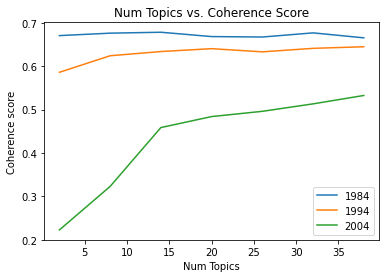

In [77]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_1984, label='1984')
plt.plot(x, coherence_values_1994, label='1994')
plt.plot(x, coherence_values_2004, label='2004')

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Num Topics vs. Coherence Score')
plt.legend()
plt.show()

Based on coherence plots for 1984, 1994, and 2004, it looks like 15-20 topics is a reasonable amount for the full dataset. We don't want our topics to be too similar to each other

# Run LDA on full dataset

### Generate and save corpus and fitted model

In [79]:
data_text = df[['question']]
for idx in range(len(data_text)):
    #go through each word in each data_text row, remove stopwords, and set them on the index.
    data_text.iloc[idx]['question'] = [word for word in data_text.iloc[idx]['question'].lower().split(' ') if word not in stopwords.words('english')]
train_headlines = [value[0] for value in data_text.iloc[0:].values]
id2word = gensim.corpora.Dictionary(train_headlines)
corpus = [id2word.doc2bow(text) for text in train_headlines]

In [80]:
import pickle
filename = 'train_headlines'
outfile = open(filename,'wb')
pickle.dump(train_headlines,outfile)
outfile.close()

In [85]:
filename = 'corpus'
outfile = open(filename,'wb')
pickle.dump(corpus,outfile)
outfile.close()

In [86]:
lda = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=15)

In [109]:
#lda.save('/Users/Lucia/Documents/USF/MSDS626_Case_Studies/jeopardy-topic-modeling/lda_trained')

# Start Running Here!

### Load saved files

In [175]:
filename = 'corpus'
infile = open(filename,'rb')
corpus = pickle.load(infile)
infile.close()

In [179]:
filename = 'lda_trained.id2word'
infile = open(filename,'rb')
id2word = pickle.load(infile)
infile.close()

In [171]:
filename = 'lda_trained'
lda_loaded = ldamodel.LdaModel.load(temp_file)

### Get LDA topics

In [123]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

get_lda_topics(lda_loaded, 15)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15
0,new,<a,"""the",war,&,&,used,&,&,&,&,state,&,,known
1,&,seen,&,world,"""the",great,&,king,played,born,first,city,greek,clue,&
2,founded,name,wrote,woman,show,work,french,family,meaning,character,president,capital,found,(<a,also
3,first,means,novel,&,century,set,make,go,use,movie,became,&,comes,crew,called
4,york,"target=""_blank"">here</a>",title,little,one,gave,type,english,classic,back,u.s.,part,name,<a,island
5,long,whose,3,based,big,took,word,major,film,came,years,national,often,i'm,american
6,country's,old,1,good,game,house,"""a",nickname,he's,first,one,named,latin,number,country
7,day,"target=""_blank"">this</a>",song,book,like,place,year,german,name,know,time,many,said,reports,british
8,former,that's,2,one,"of""",red,term,end,common,early,include,company,would,person,south
9,--,might,hit,led,museum,"these,","this,",george,they're,oscar,2,university,music,city's,river


### Topics for document 0 

In [211]:
lda.get_document_topics(corpus[0])

[(3, 0.40707853),
 (4, 0.109314956),
 (5, 0.106218316),
 (10, 0.19765902),
 (14, 0.11303881)]

This shows that there is a 40% probability that this document is in topic 3, a 10% probability that it is in topic 4, etc.

### Get best topic for each doc

In [212]:
most_likely_topic=[]
for i, _ in enumerate(corpus):
    likelihoods = dict(lda.get_document_topics(corpus[i]))
    most_likely_topic.append(max(likelihoods,key=likelihoods.get))

In [214]:
df['topic'] = most_likely_topic

In [215]:
df

,show_id,date,round,category,value,question,answer,year,topic
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004,3
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004,8
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,2004,6
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004,8
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004,12
...,...,...,...,...,...,...,...,...,...
216925,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,2000,This Puccini opera turns on the solution to 3 ...,Turandot,2006,5
216926,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",2000,In North America this term is properly applied...,a titmouse,2006,14
216927,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,2000,"In Penny Lane, where this ""Hellraiser"" grew up...",Clive Barker,2006,3
216928,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,2000,"From Ft. Sill, Okla. he made the plea, Arizona...",Geronimo,2006,11
